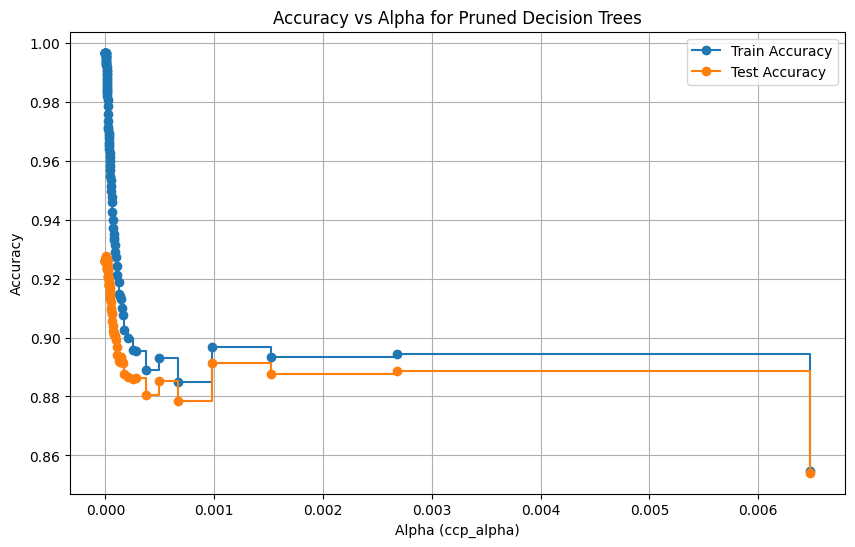

Optimal ccp_alpha: 6.977631805722575e-06
F1 Score (Pruned): 0.9280037977280355
Recall Rate (Pruned): 0.9274851050486046
MCC (Pruned): 0.8680288768221701
AUC (Pruned): 0.8505695525179467

Classification Report (Pruned):
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       125
           1       0.29      0.30      0.30        23
           2       0.40      0.41      0.40       379
           3       0.87      0.87      0.87      3204
           4       0.88      0.88      0.88       333
           5       1.00      0.99      1.00      7924
           6       1.00      1.00      1.00       421
           7       0.51      0.52      0.52       324
           8       0.57      0.52      0.55        23

    accuracy                           0.93     12756
   macro avg       0.70      0.71      0.71     12756
weighted avg       0.93      0.93      0.93     12756



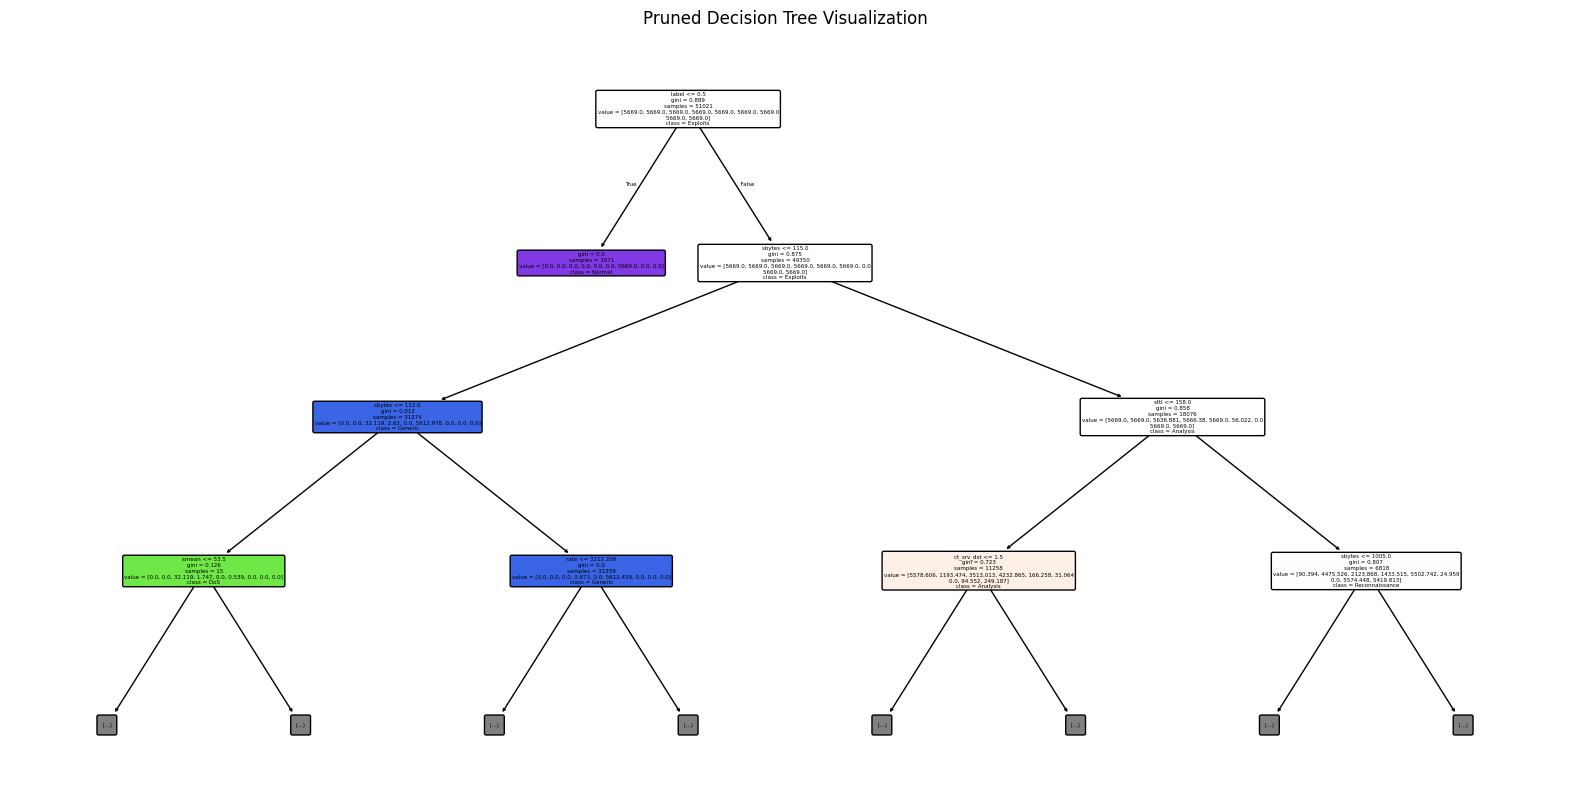

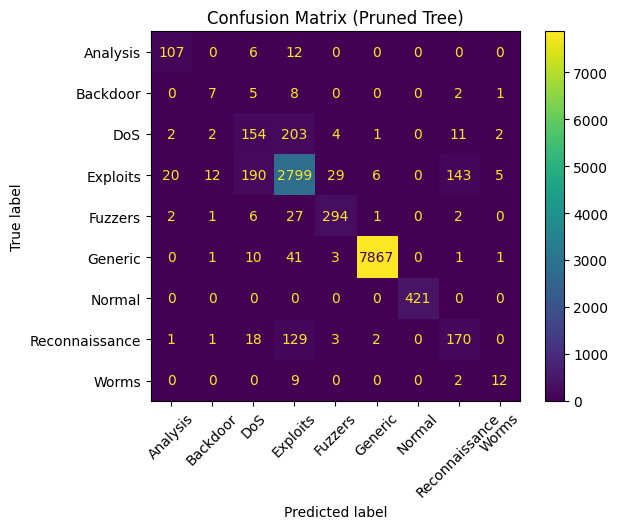

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score
)

# Load the dataset
df = pd.read_csv("Threats (1).csv")

# Data preprocessing
columns_to_drop = ['Unnamed: 0', 'id']  # Drop irrelevant columns
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Filter rows where 'service' is not '-'
df_cleaned = df_cleaned[df_cleaned['service'] != '-']

# Handle missing values
df_cleaned = df_cleaned.dropna()

# Encode categorical columns
label_encoder = LabelEncoder()
for column in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[column] = label_encoder.fit_transform(df_cleaned[column].astype(str))

# Features and target
X = df_cleaned.drop(['attack_cat'], axis=1)
y = df_cleaned['attack_cat']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree classifier
classifier = DecisionTreeClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)
# Pruning Path
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities
ccp_alphas = ccp_alphas[ccp_alphas >= 0]  # Filter non-negative alphas

# Limit the number of alphas (reduce computation)
ccp_alphas = ccp_alphas[::max(1, len(ccp_alphas) // 100)]  # Sample 50 values


# Train models for each alpha
classifiers = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, class_weight="balanced")
    clf.fit(X_train, y_train)
    classifiers.append(clf)

# Evaluate accuracy for each pruned tree
train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]

# Plot Accuracy vs Alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Alpha for Pruned Decision Trees")
plt.legend()
plt.grid()
plt.show()

# Select the optimal alpha (for demonstration, we pick the alpha with max test accuracy)
optimal_alpha = ccp_alphas[np.argmax(test_scores)]
pruned_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha, class_weight="balanced")
pruned_classifier.fit(X_train, y_train)

# Rest of the code remains the same
# Predictions for pruned tree
y_pred_pruned = pruned_classifier.predict(X_test)
y_pred_proba_pruned = pruned_classifier.predict_proba(X_test)

# Evaluation Metrics for Pruned Tree
f1_pruned = f1_score(y_test, y_pred_pruned, average="weighted")
recall_pruned = recall_score(y_test, y_pred_pruned, average="weighted")
mcc_pruned = matthews_corrcoef(y_test, y_pred_pruned)
auc_pruned = roc_auc_score(y_test, y_pred_proba_pruned, multi_class="ovr")

print("Optimal ccp_alpha:", optimal_alpha)
print("F1 Score (Pruned):", f1_pruned)
print("Recall Rate (Pruned):", recall_pruned)
print("MCC (Pruned):", mcc_pruned)
print("AUC (Pruned):", auc_pruned)
print("\nClassification Report (Pruned):\n", classification_report(y_test, y_pred_pruned))

# Decision Tree Visualization for Pruned Tree
plt.figure(figsize=(20, 10))
plot_tree(
    pruned_classifier,
    feature_names=X.columns,
    class_names=label_encoder.inverse_transform(range(len(np.unique(y)))),
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title("Pruned Decision Tree Visualization")
plt.show()

# Confusion Matrix for Pruned Tree
unique_classes = np.unique(y_test)
class_labels = label_encoder.inverse_transform(unique_classes)

ConfusionMatrixDisplay.from_estimator(
    pruned_classifier,
    X_test,
    y_test,
    display_labels=class_labels,
    cmap="viridis",
    xticks_rotation=45
)
plt.title("Confusion Matrix (Pruned Tree)")
plt.show()
